In [1]:
from __future__ import print_function
import nibabel as nib
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.externals import joblib
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import statsmodels
from statsmodels.regression.linear_model import OLS  # includes AIC, BIC
import tqdm

%matplotlib inline
sns.set()
sns.set_style("ticks")


### Load brain data

In [2]:
mvp_VBM = joblib.load('mvp/mvp_vbm.jl')
mvp_TBSS = joblib.load('mvp/mvp_tbss.jl')

... and brain size

In [3]:
brain_size = pd.read_csv('./mvp/PIOP1_behav_2017_MVCA_with_brainsize.tsv', sep='\t', index_col=0)

# Remove subjects without known brain size (or otherwise excluded from dataset)
include_subs = np.in1d(brain_size.index.values, mvp_VBM.subject_list)
brain_size = brain_size.loc[include_subs]

brain_size_VBM = brain_size.brain_size_GM.values
brain_size_TBSS = brain_size.brain_size_WM.values

#### Calculate correlations between voxels & brain size
Check-out linear, cubic, and quadratic correlation

In [4]:
if os.path.isfile('./cache/r2s_VBM.tsv'):
    r2s_VBM = pd.read_csv('./cache/r2s_VBM.tsv', sep='\t', index_col=0).values
else:
    # Calculate R2 by-voxel with polynomial models of degrees 1, 2, 3 (linear, quadratic, cubic)

    r2s_VBM = np.empty((mvp_VBM.X.shape[1], 3))  # col 1 = Linear, col 2 = Poly2, col 3 = Poly3

    # make feature vecs
    X_linear = PolynomialFeatures(degree=1).fit_transform(brain_size_VBM.reshape(-1,1))
    X_poly2 = PolynomialFeatures(degree=2).fit_transform(brain_size_VBM.reshape(-1,1))
    X_poly3 = PolynomialFeatures(degree=3).fit_transform(brain_size_VBM.reshape(-1,1))

    for i in tqdm.tqdm_notebook(range(r2s_VBM.shape[0])):
        r2s_VBM[i,0] = OLS(mvp_VBM.X[:,i], X_linear).fit().rsquared
        r2s_VBM[i,1] = OLS(mvp_VBM.X[:,i], X_poly2).fit().rsquared
        r2s_VBM[i,2] = OLS(mvp_VBM.X[:,i], X_poly3).fit().rsquared

    # save to disk
    pd.DataFrame(r2s_VBM).to_csv('./cache/r2s_VBM.tsv', sep='\t')

In [5]:
# Repeat for TBSS
if os.path.isfile('./cache/r2s_TBSS.tsv'):
    r2s_TBSS = pd.read_csv('./cache/r2s_TBSS.tsv', sep='\t', index_col=0).values
else:
    r2s_TBSS = np.empty((mvp_TBSS.X.shape[1], 3))

    # make feature vecs
    X_linear = PolynomialFeatures(degree=1).fit_transform(brain_size_TBSS.reshape(-1,1))
    X_poly2 = PolynomialFeatures(degree=2).fit_transform(brain_size_TBSS.reshape(-1,1))
    X_poly3 = PolynomialFeatures(degree=3).fit_transform(brain_size_TBSS.reshape(-1,1))

    for i in tqdm.tqdm_notebook(range(r2s_TBSS.shape[0])):
        r2s_TBSS[i,0] = OLS(mvp_TBSS.X[:,i], X_linear).fit().rsquared
        r2s_TBSS[i,1] = OLS(mvp_TBSS.X[:,i], X_poly2).fit().rsquared
        r2s_TBSS[i,2] = OLS(mvp_TBSS.X[:,i], X_poly3).fit().rsquared
        
    # save to disk
    pd.DataFrame(r2s_TBSS).to_csv('./cache/r2s_TBSS.tsv', sep='\t')

#### Function for plotting

In [27]:
def plot_voxel(voxel_idx, data, brain_size, ax=None, add_title=False, scale_bs=False, **kwargs):
    
    try:
        len(voxel_idx)
    except:
        voxel_idx = [voxel_idx]
        
    # Useful for plotting regression lines later
    # scale brain size first
    if scale_bs:
        brain_size = StandardScaler().fit_transform(brain_size.reshape(-1,1))

    bs_range = np.linspace(np.min(brain_size), np.max(brain_size), num=500)
    bs_range_poly2 = PolynomialFeatures(degree=2).fit_transform(bs_range.reshape(-1,1))
    bs_range_poly3 = PolynomialFeatures(degree=3).fit_transform(bs_range.reshape(-1,1))
    bs_range_intercept = PolynomialFeatures(degree=1).fit_transform(bs_range.reshape(-1,1))
    
    model_names = ['Linear', 'Poly2', 'Poly3']
    X_linear = PolynomialFeatures(degree=1).fit_transform(brain_size.reshape(-1,1))
    X_poly2 = PolynomialFeatures(degree=2).fit_transform(brain_size.reshape(-1,1))
    X_poly3 = PolynomialFeatures(degree=3).fit_transform(brain_size.reshape(-1,1))
    
    n_voxels = len(voxel_idx)
    nrow = int(np.ceil(n_voxels/2.))
    ncol = 2 if n_voxels > 1 else 1

    if ax is None:
        # create fig and axis if not passed to function
        f, axis = plt.subplots(nrow, ncol)
    else:
        axis = ax

    for i, idx in enumerate(voxel_idx):
        # Get data
        y = data[:,idx]

        # Fit overall model (no CV)
        lr_linear = OLS(y, X_linear).fit()
        lr_poly2 = OLS(y, X_poly2).fit()
        lr_poly3 = OLS(y, X_poly3).fit()

        # Get axis
        this_ax = axis if n_voxels == 1 else plt.subplot(nrow, ncol, i+1)

        sns.regplot(x=X_linear[:,1], y=y, ax=this_ax,
                    dropna=True, fit_reg=False, lowess=False, scatter=True, **kwargs)

        this_ax.plot(bs_range, lr_linear.predict(bs_range_intercept), 'r-', label='Linear')
        this_ax.plot(bs_range, lr_poly2.predict(bs_range_poly2), 'b-', label='Quadratic')
        this_ax.plot(bs_range, lr_poly3.predict(bs_range_poly3), 'y-', label='Cubic')

#        this_ax.legend()
        
        if add_title:
            this_ax.set_title('Voxel %d' %i)
        if scale_bs:
            this_ax.set_xlabel('Brain size (scaled)')
        else:
            this_ax.set_xlabel('Brain size')
        this_ax.set_ylabel('Intensity')

    if ax is None:
        return f, axis

#### Inner function for cross-validation. This does the work.

In [7]:
def do_crossval(voxel_idx, data, brain_size, n_iter=100, n_fold=10):
    
    # make sure voxel_idx has a len
    try:
        len(voxel_idx)
    except:
        voxel_idx = [voxel_idx]
    
    # Create feature vectors out of brain size
        X_linear = PolynomialFeatures(degree=1).fit_transform(brain_size.reshape(-1,1))
    X_poly2 = PolynomialFeatures(degree=2).fit_transform(brain_size.reshape(-1,1))
    X_poly3 = PolynomialFeatures(degree=3).fit_transform(brain_size.reshape(-1,1))
    
    # Output dataframes for crossvalidation and BIC
    results_CV = pd.DataFrame(columns=['voxel_idx', 'iter', 'Linear', 'Poly2', 'Poly3'])
    results_CV['voxel_idx'] = np.repeat(voxel_idx, n_iter)
    results_CV['iter'] = np.tile(np.arange(n_iter), len(voxel_idx))

    results_BIC = pd.DataFrame(columns=['voxel_idx', 'Linear', 'Poly2', 'Poly3'])
    results_BIC['voxel_idx'] = voxel_idx
    
    for i, idx in enumerate(voxel_idx):
        
        # Get target data (vbm intensity)
        y = data[:,idx]

        # Make pipeline
        pipe = make_pipeline(StandardScaler(), LinearRegression())

        Xdict = {'Linear': X_linear, 'Poly2': X_poly2, 'Poly3': X_poly3}

        for iteration in range(n_iter):
            if n_iter > 10:
                if iteration % int(n_iter/10) == 0:
                    print('.', end='')

            # KFold inside loop for shuffling
            cv = KFold(n_splits=n_fold, random_state=iteration, shuffle=True)

            # get row idx in results DataFrame
            row_idx = (results_CV['voxel_idx']==idx)&(results_CV['iter']==iteration)

            for model_type, X in Xdict.items():
                r2 = cross_val_score(pipe, X=X, y=y, cv=cv).mean()
                results_CV.loc[row_idx, model_type] = cross_val_score(pipe, X=X, y=y, cv=cv).mean()

        # add BIC info
        # Fit overall model (no CV)
        lr_linear = OLS(y, X_linear).fit()
        lr_poly2 = OLS(y, X_poly2).fit()
        lr_poly3 = OLS(y, X_poly3).fit()

        # get BICs of fitted models, add to output dataframe
        bics = [lr_linear.bic, lr_poly2.bic, lr_poly3.bic]
        results_BIC.loc[results_BIC['voxel_idx']==idx, 'Linear'] = lr_linear.bic
        results_BIC.loc[results_BIC['voxel_idx']==idx, 'Poly2'] = lr_poly2.bic
        results_BIC.loc[results_BIC['voxel_idx']==idx, 'Poly3'] = lr_poly3.bic
    
    return [results_CV, results_BIC]

#### Wrapper function for multiprocessing

In [8]:
import multiprocessing
from functools import partial
import tqdm

def run_CV_MP(data, voxel_idx, brain_size, n_iter, n_processes=10, n_fold=10, pool=None):
    if pool is None:
        private_pool = True
        pool = multiprocessing.Pool(processes=n_processes)
    else:
        private_pool = False
        
    results_all_vox = []
    with tqdm.tqdm(total=len(voxel_idx)) as pbar:
        for i, res in tqdm.tqdm(enumerate(pool.imap_unordered(partial(do_crossval,
                                                                        data=data,
                                                                        brain_size=brain_size,
                                                                        n_fold=10,
                                                                        n_iter=n_iter), voxel_idx))):
            results_all_vox.append(res)
           
    if private_pool:
        pool.terminate()
    return results_all_vox

## Cross-validation

In [9]:
# How many iterations do we want? Iterations are repeats of KFold CV with random partitioning of the data, 
# to ensure that the results are not dependent on the (random) partitioning
n_iter = 50

# How many voxels should we take?
n_voxels = 500

# # What modality are we in?
# modality = 'VBM'

# # Which voxels are selected?
# voxel_type = 1  # 0 = linear, 1 = poly2, 2 = poly3

#### Cross-validate for all combinations of modality & relation type
2 modalitites (TBSS, VBM) x 4 relation types (linear, quadratic, cubic, random) = 8 options in total. Each takes about an hour here

In [ ]:
# set-up pool here so we can terminate if necessary
pool = multiprocessing.Pool(processes=10)

for modality in ['VBM', 'TBSS']:
    # select right mvp & brain size
    mvp = mvp_VBM if modality == 'VBM' else mvp_TBSS
    brain_size = brain_size_VBM if modality == 'VBM' else brain_size_TBSS

    for relation_type in [0, 1, 2, 3]:
        print('Processing %s, type %d' %(modality, relation_type))
        if relation_type < 3:
            # linear, quadratic, cubic relations?
            corrs = r2s_VBM[:,relation_type] if modality == 'VBM' else r2s_TBSS[:,relation_type]
            vox_idx = corrs.argsort()[-n_voxels:]  # these are the voxel idx with highest r2
        else:
            # random voxels
            vox_idx = np.random.choice(np.arange(mvp.X.shape[1]), replace=False, size=n_voxels)
        
        # Run multiprocessed
        output = run_CV_MP(data=mvp.X, voxel_idx=vox_idx, brain_size=brain_size, n_iter=n_iter, pool=pool)

        # Save results
        tmp = pd.concat([x[0] for x in output], ignore_index=True)
        tmp.to_csv('./cache/results_%s_type-%d_nvox-%d.tsv' %(modality, relation_type, n_voxels), sep='\t')

  0%|          | 0/500 [00:00<?, ?it/s]


Processing VBM, type 0


0it [00:00, ?it/s]
1it [00:40, 40.81s/it]
2it [01:04, 32.41s/it]
3it [01:09, 23.06s/it]
4it [01:19, 19.87s/it]
5it [01:35, 19.03s/it]
6it [01:36, 16.01s/it]
7it [01:36, 13.76s/it]
8it [01:42, 12.84s/it]
9it [01:46, 11.80s/it]
10it [01:50, 11.01s/it]
11it [01:59, 10.89s/it]
12it [02:18, 11.55s/it]
13it [02:18, 10.67s/it]
14it [02:40, 11.47s/it]
15it [03:01, 12.10s/it]
16it [03:02, 11.39s/it]
17it [03:13, 11.40s/it]
18it [03:17, 11.00s/it]
19it [03:22, 10.67s/it]
21it [03:23,  9.69s/it]
22it [03:42, 10.13s/it]
23it [03:43,  9.73s/it]
24it [04:08, 10.34s/it]
25it [04:23, 10.52s/it]
26it [04:29, 10.36s/it]
27it [04:34, 10.18s/it]
28it [04:39,  9.99s/it]
29it [04:39,  9.65s/it]
30it [04:54,  9.81s/it]
31it [05:03,  9.79s/it]
32it [05:07,  9.62s/it]
33it [05:13,  9.50s/it]
34it [05:34,  9.82s/it]
35it [05:41,  9.77s/it]
36it [05:58,  9.96s/it]
37it [06:06,  9.89s/it]
38it [06:12,  9.79s/it]
39it [06:12,  9.56s/it]
40it [06:18,  9.46s/it]
41it [06:21,  9.31s/it]
42it [06:38,  9.48s/it]
43it [

Load all results, make Supplementary Figures S7 (VBM) and S9 (TBSS)

In [37]:
modality = 'VBM'
mvp = mvp_VBM if modality == 'VBM' else mvp_TBSS
brain_size = brain_size_VBM if modality == 'VBM' else brain_size_TBSS
results_linear_vox = pd.read_csv('./cache/results_%s_type-%d_nvox-%d.tsv' %(modality, 0, n_voxels), sep='\t')
results_poly2_vox = pd.read_csv('./cache/results_%s_type-%d_nvox-%d.tsv' %(modality, 1, n_voxels), sep='\t')
results_poly3_vox = pd.read_csv('./cache/results_%s_type-%d_nvox-%d.tsv' %(modality, 2, n_voxels), sep='\t')
results_random_vox = pd.read_csv('./cache/results_%s_type-%d_nvox-%d.tsv' %(modality, 3, n_voxels), sep='\t')

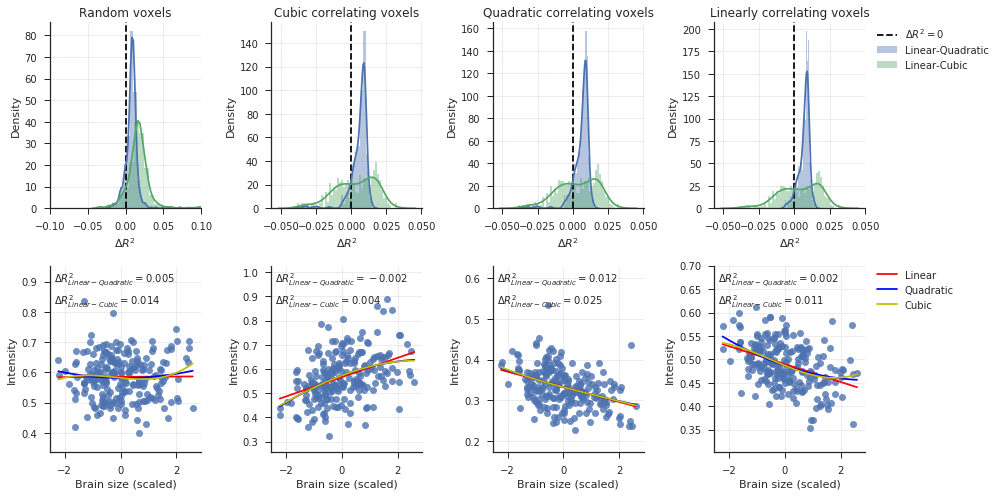

In [38]:
sns.set_style('ticks')
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# set seed
seed = 2 if modality == 'TBSS' else 4
np.random.seed(seed)

f, ax = plt.subplots(2, 4)

to_plot = [{'Random voxels': results_random_vox}, 
           {'Cubic correlating voxels': results_poly2_vox},
           {'Quadratic correlating voxels': results_poly3_vox},
           {'Linearly correlating voxels': results_linear_vox}]
labels = ['Linear-Quadratic', 'Linear-Cubic']

for col, d in enumerate(to_plot):
    title = list(d.keys())[0]
    results = d[title]
    
    # For every voxel & iter, how much better does the linear model do compared to the polynomial models?
    results['Linear-Poly2'] = results['Linear']-results['Poly2']
    results['Linear-Poly3'] = results['Linear']-results['Poly3']

    # Mean over iterations to get results by voxel
    results_by_voxel = results.groupby('voxel_idx')[['Linear-Poly2', 'Linear-Poly3']].mean()

    # plot histogram
    this_ax = ax[0, col]
    this_ax.axvline(x=0, color='k', ls='--', label='$\Delta R^2=0$')    # add line at 0
    for i, model in enumerate(['Linear-Poly2', 'Linear-Poly3']):
        sns.distplot(results_by_voxel[model], ax=this_ax, kde=True, hist=True, label=labels[i], bins=n_voxels/10)

    # Set some stuff (labels, title, legend)
    this_ax.set_xlabel('$\Delta R^2$')
    this_ax.set_ylabel('Density')
    this_ax.set_title(title)
    
    if col == 0 and modality == 'VBM':
        this_ax.set_xlim(-.1, .1)

    # Select random voxel
    plot_vox_idx = np.random.choice(results_by_voxel.index.values, size=1)

    # plot this voxel's correlation with brain size, plus the three models
    plot_voxel(plot_vox_idx, mvp.X, brain_size, ax=ax[1, col], color=sns.color_palette()[0], scale_bs=True)
    # scale bs here for axis ticks readability
    
    # add text
    # increase ylm by 10%
    ax[1,col].set_ylim(ax[1,col].get_ylim()[0], ax[1,col].get_ylim()[0]+(ax[1,col].get_ylim()[1]-ax[1,col].get_ylim()[0])*1.1)
    r2_lq = results_by_voxel.loc[plot_vox_idx, 'Linear-Poly2']
    r2_lc = results_by_voxel.loc[plot_vox_idx, 'Linear-Poly3']
    ax[1,col].text(0.025, .975,'$\Delta R^2_{Linear-Quadratic}=%.3f$\n$\Delta R^2_{Linear-Cubic}=%.3f$' %(r2_lq, r2_lc),
             horizontalalignment='left',
             verticalalignment='top', 
             transform=ax[1,col].transAxes)
    
    # add grid
    this_ax.grid(ls='--', lw=.5)
    ax[1,col].grid(ls='--', lw=.5)
    
    if col == len(to_plot)-1:
        this_ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        ax[1, col].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

sns.despine()
f.set_size_inches(14,7)
f.tight_layout()
f.savefig('./figs/brain_size_vs_%s_intensity.png' %modality, bbox_type='tight', dpi=200)

And descriptives?

In [39]:
to_plot = [{'Random voxels': results_random_vox}, 
           {'Cubic correlating voxels': results_poly2_vox},
           {'Quadratic correlating voxels': results_poly3_vox},
           {'Linearly correlating voxels': results_linear_vox}]
labels = ['Linear-Quadratic', 'Linear-Cubic']

for col, d in enumerate(to_plot):
    title = list(d.keys())[0]
    results = d[title]
    
    # For every voxel & iter, how much better does the linear model do compared to the polynomial models?
    results['Linear-Poly2'] = results['Linear']-results['Poly2']
    results['Linear-Poly3'] = results['Linear']-results['Poly3']

    # Mean over iterations to get results by voxel
    results_by_voxel = results.groupby('voxel_idx')[['Linear-Poly2', 'Linear-Poly3']].mean()
    
    
    print('For the %s:\n-linear models have a mean +%.3f R^2 (SD %.3f, min: %.3f) than quadratic models, '
          '\n-and %.3f (SD %.3f, max: %.3f) over cubic models. \n-A proportion of %.3f of voxels prefers a quadratic model, '
          'and a proportion of %.3f prefers a cubic model\n\n'%(title, 
                                         results_by_voxel['Linear-Poly2'].mean(), 
                                         results_by_voxel['Linear-Poly2'].std(),
                                         results_by_voxel['Linear-Poly2'].min(),
                                         results_by_voxel['Linear-Poly3'].mean(),
                                         results_by_voxel['Linear-Poly3'].std(),
                                         results_by_voxel['Linear-Poly3'].min(),
                                         np.mean(results_by_voxel['Linear-Poly2']<0),
                                         np.mean(results_by_voxel['Linear-Poly3']<0)))

For the Random voxels:
-linear models have a mean +0.009 R^2 (SD 0.014, min: -0.024) than quadratic models, 
-and 0.019 (SD 0.027, max: -0.036) over cubic models. 
-A proportion of 0.134 of voxels prefers a quadratic model, and a proportion of 0.092 prefers a cubic model


For the Cubic correlating voxels:
-linear models have a mean +0.006 R^2 (SD 0.007, min: -0.040) than quadratic models, 
-and 0.003 (SD 0.015, max: -0.039) over cubic models. 
-A proportion of 0.106 of voxels prefers a quadratic model, and a proportion of 0.422 prefers a cubic model


For the Quadratic correlating voxels:
-linear models have a mean +0.006 R^2 (SD 0.006, min: -0.036) than quadratic models, 
-and 0.003 (SD 0.014, max: -0.039) over cubic models. 
-A proportion of 0.096 of voxels prefers a quadratic model, and a proportion of 0.424 prefers a cubic model


For the Linearly correlating voxels:
-linear models have a mean +0.007 R^2 (SD 0.004, min: -0.006) than quadratic models, 
-and 0.004 (SD 0.014, max: -0

Supplementary Figure S8

-0.0357580830296
-0.0387817539704
0.032486994328


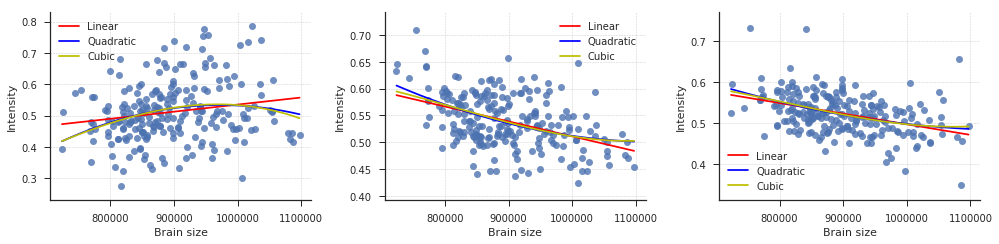

In [31]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

f, ax = plt.subplots(1, 3)

to_plot = [{'Random voxels': results_random_vox}, 
           {'Cubic correlating voxels': results_poly2_vox}]
labels = ['Linear-Quadratic', 'Linear-Cubic']

for col, d in enumerate(to_plot):
    title = list(d.keys())[0]
    results = d[title]
    
    # For every voxel & iter, how much better does the linear model do compared to the polynomial models?
    results['Linear-Poly2'] = results['Linear']-results['Poly2']
    results['Linear-Poly3'] = results['Linear']-results['Poly3']

    # Mean over iterations to get results by voxel
    results_by_voxel = results.groupby('voxel_idx')[['Linear-Poly2', 'Linear-Poly3']].mean()

    # plot histogram
    this_ax = ax[col]

    # Select voxels where poly3 wins by largest margin, for plotting
    plot_vox = np.argmin(results_by_voxel['Linear-Poly3'])
    print(results_by_voxel.loc[plot_vox, 'Linear-Poly3'])

    # plot this voxel's correlation with brain size, plus the three models
    plot_voxel(plot_vox, mvp.X, brain_size, ax=ax[col], color=sns.color_palette()[0])

    ax[col].legend()
    ax[col].grid(ls='--', lw=.5)


# Add a voxel where a linear model fits nicely
results = results_linear_vox
results_by_voxel = results.groupby('voxel_idx')[['Linear-Poly2', 'Linear-Poly3']].mean()
plot_vox = np.argmax(results_by_voxel['Linear-Poly3'])

# plot this voxel's correlation with brain size, plus the three models
plot_voxel(plot_vox, mvp.X, brain_size, ax=ax[2], color=sns.color_palette()[0])
ax[2].legend()
ax[2].grid(ls='--', lw=.5)
print(results_by_voxel.loc[plot_vox, 'Linear-Poly3'])

sns.despine()
f.set_size_inches(14,3.5)
f.tight_layout()
f.savefig('./figs/bs_vs_vox.png', bbox_type='tight', dpi=200)

### Conclusions

Together, the results show that a linear model is a good approximation of the relation between VBM/TBSS voxel intensity and brain size